In [1]:
import torch
import numpy as np
import datasets
import os
import umap
import evaluate
import accelerate
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict
from torch import nn
from torch.nn import functional as F
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from pprint import pprint
from scipy.stats import spearmanr
from tqdm import tqdm
from multiprocessing import Pool

# mltk stuff
import mltoolkit as mltk
from mltoolkit.utils import files, display
os.chdir(files.project_root())
display.note(f'changed directory to \'{os.getcwd()}\'')

datasets.disable_caching()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/data/john/projects/nb/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-08 11:10:35.459792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 11:10:36.110923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[NOTE] changed directory to '/data/john/projects/mltoolkit'


In [3]:

ds = datasets.load_dataset(
    'wikipedia',
    '20220301.en',
    cache_dir='./data/cache',
    trust_remote_code=True,
)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 6458670
    })
})


In [13]:
num_proc = 10
#data = ds['train'][:]

def map_fn(x):
    return len(sent_tokenize(x['text']))

with Pool(num_proc) as p:
    counts = list(p.imap(
        map_fn,
        ds['train'],
    ))


KeyboardInterrupt: 

0.9350


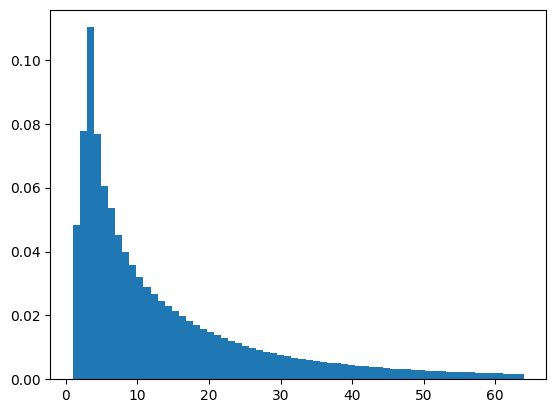

In [14]:
max_number = 64
sent_counts = np.load('/data/john/files/wikipedia_sent_counts.npy')
sent_counts_filtered = sent_counts[sent_counts <= max_number]
print(f'{len(sent_counts_filtered) / len(sent_counts):.04f}')
_ = plt.hist(sent_counts_filtered, bins=max_number, density=True)

# Notes from counting sentences

| $t$ | $\frac{1}{N}\sum\limits_{i}^{N} 1(\text{CountSents}(d_i) \leq t)$ |
| --- | ----------------------------------------------------------------- |
| $512$ | .9999                                                           |
| $256$ | .9946                                                           |
| $128$ | .9789                                                           |
| $64$  | .9350                                                           |
